# Getting started

Once you've chosen your scenario, download the data from [the Iowa website](https://data.iowa.gov/Economy/Iowa-Liquor-Sales/m3tr-qhgy) in csv format. Start by loading the data with pandas. You may need to parse the date columns appropriately.

In [93]:
# Import relevant libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
%matplotlib inline

In [94]:
# Format how pandas returns floats
pd.set_option('display.float_format', '{:.2f}'.format)

In [95]:
# We decided to bring in external data so we'll be reading from three files
# Write a function that loads the data and returns a dataframe
def load_file(file_name):
    file_path_name = base_path + file_name
    try:
        return pd.read_csv(file_path_name, low_memory=False)
    except:
        print 'Error: Check file path/ name'

In [96]:
# Define our base path
base_path = '/Users/joce/learning/data_science/project-3-datasets/'

In [97]:
## Load the liquor sales data into a DataFrame
df = load_file('Iowa_Liquor_sales_sample_10pct.csv')

In [98]:
## Transform the dates if needed, e.g.
df["Date"] = pd.to_datetime(df["Date"], format='%m/%d/%Y')

In [99]:
# To facilitate using a bigger file later, we'll keep just the columns that are available in this dataset
all_columns = df.columns.values.tolist()
df = df.copy()[all_columns]
df.head()

,Date,Store Number,City,Zip Code,County Number,County,Category,Category Name,Vendor Number,Item Number,Item Description,Bottle Volume (ml),State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Liters),Volume Sold (Gallons)
0,2015-11-04,3717,SUMNER,50674,9.00,Bremer,1051100.00,APRICOT BRANDIES,55,54436,Mr. Boston Apricot Brandy,750,$4.50,$6.75,12,$81.00,9.00,2.38
1,2016-03-02,2614,DAVENPORT,52807,82.00,Scott,1011100.00,BLENDED WHISKIES,395,27605,Tin Cup,750,$13.75,$20.63,2,$41.26,1.50,0.40
2,2016-02-11,2106,CEDAR FALLS,50613,7.00,Black Hawk,1011200.00,STRAIGHT BOURBON WHISKIES,65,19067,Jim Beam,1000,$12.59,$18.89,24,$453.36,24.00,6.34
3,2016-02-03,2501,AMES,50010,85.00,Story,1071100.00,AMERICAN COCKTAILS,395,59154,1800 Ultimate Margarita,1750,$9.50,$14.25,6,$85.50,10.50,2.77
4,2015-08-18,3654,BELMOND,50421,99.00,Wright,1031080.00,VODKA 80 PROOF,297,35918,Five O'clock Vodka,1750,$7.20,$10.80,12,$129.60,21.00,5.55


To ensure accuracy, we are importing a list of Iowa zip codes, cities, counties and county numbers for the purposes of cleaning our data. We obtained our data from [here](http://www.unitedstateszipcodes.org/zip-code-database/), [here](http://www.iowayouthsurvey.iowa.gov/images/iacountiesnumbers.pdf) and [here](https://www.census.gov/geo/maps-data/data/tiger-line.html).

In [100]:
# Load in our location data file
location_data = load_file('ia_zip_city_county_sqkm.csv')
location_data = location_data.drop(location_data.columns[0], axis=1)
location_data['Zip Code'] = location_data['Zip Code'].astype(str)
location_data.head()

,Zip Code,City,County,State,County Number,Area (sqkm)
0,50001,ACKWORTH,Warren,IA,91,62.80
1,50002,ADAIR,Guthrie,IA,39,279.20
2,50003,ADEL,Dallas,IA,25,298.09
3,50005,ALBION,Marshall,IA,64,69.62
4,50006,ALDEN,Hardin,IA,42,317.75


Our hypothesis is that the demographics of an area affects the liquor sales. To test this, we brought in demographic data from [here](http://www.iowadatacenter.org/browse/ZCTAs.html).

In [101]:
# Load in our demographic data file
demo_data = load_file('IowaZIPdemos.csv')

# Remove any rows with null values
demo_data.dropna(inplace=True)


In [110]:
# All our data should be integers or floats
# Create a list of column names if those columns are objects
demo_cols = demo_data.columns.values.tolist()
object_cols = [i for i in demo_cols if demo_data[i].dtype == 'O']

# Define a function to remove symbols and convert numbers to floats
def rem_symbols(x):
    for i in [',', '%', '$', '-']:
        x = x.replace(i, '')
    try:
        return float(x)
    except:
        print x

# Convert all columns to floats
for i in object_cols:
    demo_data[i] = demo_data[i].map(rem_symbols)

# Convert zips to strings for easy comparison
demo_data['Area'] = demo_data['Area'].astype(str)
demo_data['Area'] = demo_data['Area'].map(lambda x: x.strip('.0'))
demo_data.head()

,Area,Total Pop,Median HH Inc,Per Capita Inc,White,Afr Amer,Native Amer,Asian Amer,Pac Islander,Other,...,Family households,Married-couple family households,Single mother households,Nonfamily households,Single Occupancy,Avg HH Size,Avg Family Size,Pop Below Poverty Level,% P25+ HS Grad,% P25-54 BA+
0,50001,615.00,43611.00,17803.00,594.00,3.00,1.00,0.00,0.00,2.00,...,174.00,158.00,12.00,42.00,34.00,2.85,3.21,711.00,88.80,9.70
1,50002,1339.00,32500.00,20580.00,1323.00,0.00,1.00,5.00,0.00,2.00,...,370.00,333.00,30.00,205.00,185.00,2.25,2.86,1232.00,87.60,11.20
2,50003,5835.00,47649.00,22429.00,5733.00,8.00,6.00,22.00,0.00,23.00,...,1615.00,1390.00,162.00,619.00,529.00,2.58,3.08,5816.00,91.00,24.00
3,50005,851.00,41786.00,15267.00,840.00,0.00,5.00,4.00,0.00,0.00,...,251.00,208.00,28.00,69.00,56.00,2.66,2.98,917.00,80.80,12.70
4,50006,1959.00,36494.00,16957.00,1930.00,0.00,1.00,3.00,0.00,21.00,...,547.00,477.00,43.00,220.00,194.00,2.55,3.09,1939.00,88.90,14.80


## Cleaning the data

We will run a check on zip codes before joining the liquor sales data and the location data.

In [111]:
# Create a list of unique zip codes in the liquor sales data
liquor_zips = df['Zip Code'].drop_duplicates().tolist()

# Create a list of unique zip codes as strings from the location data
ref_zips = location_data['Zip Code'].tolist()

# Create a list of zip codes that are present in the liquor sales data but not in the location data
not_found = [x for x in liquor_zips if x not in ref_zips]
print not_found

['0']


In [112]:
# For each 'unknown' zip code, we obtain the corresponding city, county and county number in the liquor sales data
# and return the same data for that city in our location data
for i in not_found:
    print df[['Zip Code', 'City', 'County', 'County Number']][df['Zip Code'] == i].drop_duplicates()
    city = df['City'][df['Zip Code'] == i].drop_duplicates().iloc[0].upper()
    print city
    try:
        print location_data[location_data['City']==city].drop_duplicates()
    except:
        print i, 'not in Iowa'
    print

    Zip Code      City    County  County Number
496        0  DELAWARE  Delaware          28.00
DELAWARE
Empty DataFrame
Columns: [Zip Code, City, County, State, County Number, Area (sqkm)]
Index: []



Based on the above, we can kind of see what these zip codes are supposed to be.  
Note: We will only be able to do this for a small dataset. As the dataset gets larger, more 'unknown' zips may appear and we may not be able to clean this manually.  

Also note that the zip for Delaware, Delaware, Iowa is in fact correct. However, as it had a small population of 159 as at the 2010 census, we will not be considering it for the purposes of our model

In [113]:
# Create a dictionary to map the correct zip codes to the incorrect ones
# We will change 52036 to 0 so as to ignore it later on
corrected_zips = {'52303': '52403',\
                  '712-2': '51529',\
                  '52087': '52057',\
                  '52084': '52804',\
                  '52036': '0',\
                  '52733': '52732',\
                  '56201': '52601',\
                  '50300': '50309'}

for i in range(len(not_found)):
    df.ix[df['Zip Code']==corrected_zips.keys()[i], 'Zip Code']=corrected_zips.values()[i]

In [114]:
# Create a new dataframe to take the merged data
df2 = df.copy()
df2.drop(['County Number', 'City', 'County'], axis=1, inplace=True)
df2 = df2.merge(location_data, how='left', on='Zip Code')
df2.drop(['State'], axis=1, inplace=True)
df2.head()

,Date,Store Number,Zip Code,Category,Category Name,Vendor Number,Item Number,Item Description,Bottle Volume (ml),State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Liters),Volume Sold (Gallons),City,County,County Number,Area (sqkm)
0,2015-11-04,3717,50674,1051100.00,APRICOT BRANDIES,55,54436,Mr. Boston Apricot Brandy,750,$4.50,$6.75,12,$81.00,9.00,2.38,SUMNER,Bremer,9.00,408.69
1,2016-03-02,2614,52807,1011100.00,BLENDED WHISKIES,395,27605,Tin Cup,750,$13.75,$20.63,2,$41.26,1.50,0.40,DAVENPORT,Scott,82.00,76.47
2,2016-02-11,2106,50613,1011200.00,STRAIGHT BOURBON WHISKIES,65,19067,Jim Beam,1000,$12.59,$18.89,24,$453.36,24.00,6.34,CEDAR FALLS,Black Hawk,7.00,329.97
3,2016-02-03,2501,50010,1071100.00,AMERICAN COCKTAILS,395,59154,1800 Ultimate Margarita,1750,$9.50,$14.25,6,$85.50,10.50,2.77,AMES,Story,85.00,155.29
4,2015-08-18,3654,50421,1031080.00,VODKA 80 PROOF,297,35918,Five O'clock Vodka,1750,$7.20,$10.80,12,$129.60,21.00,5.55,BELMOND,Wright,99.00,232.91


In [115]:
# Write a function that cross references related columns and fills the data in where it's missing
def fill_missing(related_cols, column, dataframe):
    related_cols.remove(column)
    reference = dataframe[related_cols][dataframe[column].isnull()].drop_duplicates()
    for j in range(len(related_cols)):
        col_1 = reference[related_cols[j]]
        for i in col_1:
            try:
                x = dataframe[column][(dataframe[related_cols[j]]==i) & (dataframe[column].notnull())].drop_duplicates()
                if len(x) < 2:
                    value = x.iloc[0]
                    dataframe.ix[(dataframe[related_cols[j]]==i) & (dataframe[column].isnull()), column] = value
            except:
                pass

In [116]:
# Run our function to cross check category numbers and names
fill_missing(['Category', 'Category Name'], 'Category Name', df2)
fill_missing(['Category', 'Category Name'], 'Category', df2)

# Run our function to cross check item numbers and names
fill_missing(['Item Number', 'Item Description'], 'Item Description', df2)
fill_missing(['Item Number', 'Item Description'], 'Item Number', df2)

In [117]:
# Convert all dollar columns to floats
df2['State Bottle Cost'] = df2['State Bottle Cost'].map(lambda x: x.strip('$')).astype(float)
df2['State Bottle Retail'] = df2['State Bottle Retail'].map(lambda x: x.strip('$')).astype(float)
df2['Sale (Dollars)'] = df2['Sale (Dollars)'].map(lambda x: x.strip('$')).astype(float)


# Explore the data

Perform some exploratory statistical analysis and make some plots, such as histograms of transaction totals, bottles sold, etc.

In [118]:
# Extract Month and Year
df2['Month'] = df2['Date'].map(lambda x: x.month)
df2['Year'] = df2['Date'].map(lambda x: x.year)

In [119]:
# For the purposes of market research, we would want to look at full year data
# Find all the non full years in the data set
not_full_years = [i for i in df2['Year'].unique() if len(df2['Month'][df2['Year']==i].unique()) != 12]
not_full_years

[2016]

In [120]:
for i in not_full_years:
    df2 = df2.drop(df2[df2['Year']==i].index)

In [121]:
df2.columns.values

array(['Date', 'Store Number', 'Zip Code', 'Category', 'Category Name',
       'Vendor Number', 'Item Number', 'Item Description',
       'Bottle Volume (ml)', 'State Bottle Cost', 'State Bottle Retail',
       'Bottles Sold', 'Sale (Dollars)', 'Volume Sold (Liters)',
       'Volume Sold (Gallons)', 'City', 'County', 'County Number',
       'Area (sqkm)', 'Month', 'Year'], dtype=object)

In [134]:
def draw_histograms(data, col):
    sns.distplot(data[col].sum());
    plt.title(col);
    plt.xlabel(col);
    plt.ylabel('Frequency');
    plt.xticks(rotation=45);
    plt.show();
    print 

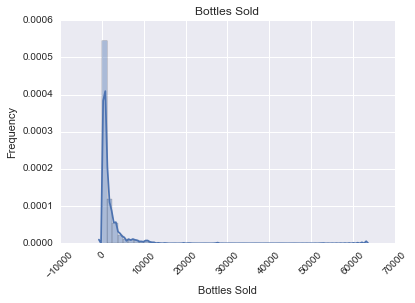

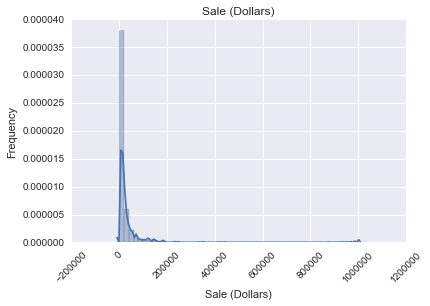

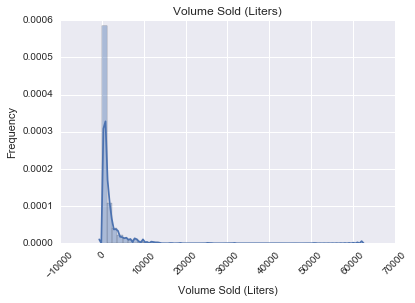

In [136]:
# Let's take a look at the distribution of 'Bottles Sold', 'Sale (Dollars)', and 'Volume Sold (Liters)'
# aggregated by store number
hist_cols = ['Bottles Sold', 'Sale (Dollars)', 'Volume Sold (Liters)']
for i in hist_cols:
    draw_histograms(df2.groupby('Store Number'), i)

We can see that there are outliers in all cases.

In [123]:
# We'll take a look at our demographic data as well
demo_data.columns.values

array(['Area', 'Total Pop', 'Median HH Inc', 'Per Capita Inc', 'White',
       'Afr Amer', 'Native Amer', 'Asian Amer', 'Pac Islander', 'Other',
       'Bi- Multi-Racial', 'Hispanic or Latino', 'Med Age', '<5 years',
       '5-17 yrs', '18-20 yrs', '21-24 yrs', '25-34 yrs', '35-44 yrs',
       '45-54 yrs', '55-59 yrs', '60-64 yrs', '65-74 yrs', '78-84 yrs',
       '85+ yrs', '% P16+ in labor force', 'Total # Homes Owned',
       'Med. Home Value', 'Tot Housing units',
       'Owner occupied housing units', 'Renter occupied housing units',
       'households', 'Family households',
       'Married-couple family households', 'Single mother households',
       'Nonfamily households', 'Single Occupancy', 'Avg HH Size',
       'Avg Family Size', 'Pop Below Poverty Level', '% P25+ HS Grad',
       '% P25-54 BA+'], dtype=object)

TypeError: len() of unsized object

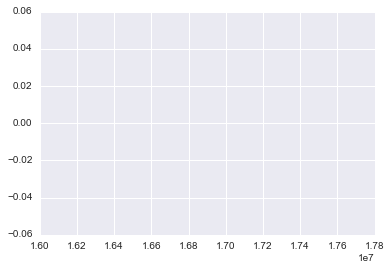

In [137]:
# We'll take a look at some of our demographic data as well
demo_hist_cols = ['Per Capita Inc', 'Pop Below Poverty Level', '% P16+ in labor force']
for i in demo_hist_cols:
    draw_histograms(demo_data, i)
#     sns.distplot(demo_data[i]);
#     plt.title(i);
#     plt.xlabel(i);
#     plt.ylabel('Frequency');
#     plt.xticks(rotation=45);
#     plt.show();
#     print 

## Record your findings

Be sure to write out anything observations from your exploratory analysis.

For the purposes of our market research, we are interested in total sales grouped by zip codes.  
To get a fair idea of how each zip code does, we would want to remove the outlier stores (stores that do exceptionally well or poor) as these may not be a good indication of how an average store would fare in that zip code.

# Mine the data
Now you are ready to compute the variables you will use for your regression from the data. For example, you may want to
compute total sales per store from Jan to March of 2015, mean price per bottle, etc. Refer to the readme for more ideas appropriate to your scenario.

Pandas is your friend for this task. Take a look at the operations [here](http://pandas.pydata.org/pandas-docs/stable/groupby.html) for ideas on how to make the best use of pandas and feel free to search for blog and Stack Overflow posts to help you group data by certain variables and compute sums, means, etc. You may find it useful to create a new data frame to house this summary data.

In [125]:
df2.columns.values

array(['Date', 'Store Number', 'Zip Code', 'Category', 'Category Name',
       'Vendor Number', 'Item Number', 'Item Description',
       'Bottle Volume (ml)', 'State Bottle Cost', 'State Bottle Retail',
       'Bottles Sold', 'Sale (Dollars)', 'Volume Sold (Liters)',
       'Volume Sold (Gallons)', 'City', 'County', 'County Number',
       'Area (sqkm)', 'Month', 'Year'], dtype=object)

In [132]:
agg_columns = ['Sale (Dollars)', 'Volume Sold (Liters)']
store_summary = df2.groupby('Store Number')[agg_columns].sum().reset_index()

In [133]:
for i in agg_columns:
    

SyntaxError: invalid syntax (<ipython-input-133-82b8cfa03e90>, line 1)

# Refine the data
Look for any statistical relationships, correlations, or other relevant properties of the dataset.

# Build your models

Using scikit-learn or statsmodels, build the necessary models for your scenario. Evaluate model fit.

## Plot your results

Again make sure that you record any valuable information. For example, in the tax scenario, did you find the sales from the first three months of the year to be a good predictor of the total sales for the year? Plot the predictions versus the true values and discuss the successes and limitations of your models

# Present the Results

Present your conclusions and results. If you have more than one interesting model feel free to include more than one along with a discussion. Use your work in this notebook to prepare your write-up.